# Goodreads Reviews Dataset Exploration

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
goodreads_df = pd.read_csv('goodreads-reviews-full-dataset.csv')

## EDA on the dataset

In [ ]:
goodreads_df.head()

In [ ]:
goodreads_df.info()

In [ ]:
goodreads_df.describe()

In [ ]:
goodreads_df.shape

In [ ]:
goodreads_df.isnull().sum()

In [ ]:
goodreads_df['review score'].value_counts()

In [ ]:
goodreads_df.dtypes

## Getting review word count

### Using a sample dataframe to test

In [12]:
sample_df = goodreads_df.sample(50)
sample_df.head()

,review score,review text
8008,4,"""Nothing ever happens like you imagine it will..."
9867,4,Yayyy!!!! Finally I could read a classic-crime...
4937,5,Another classic. If you don't like this series...
10,1,A lot of things are troubling me about The Hun...
7115,4,I've been completely fangirling over Gillian F...


In [ ]:
sample_df['review_word_count'] = sample_df['review text'].str.split().apply(len)

In [ ]:
sample_df.head()

In [ ]:
sample_df['review_word_count'].hist()

### Now doing the same on the full df

In [ ]:
goodreads_df['review_word_count'] = goodreads_df['review text'].str.split().apply(len)

In [ ]:
goodreads_df['review_word_count'].hist(bins=20)

In [ ]:
goodreads_df.describe()

This shows that there are some outliers in terms of review size, but the majority of reviews are under 500 words. Therefore, will be trimming the review length to around 500 words and padding up to there as a starting point, and potentially trimming it further if it would speed up the process. I think I will keep the last 500 word of longer reviews, as they are more likely to be representative of the associated review score from the conclusion.

In [ ]:
goodreads_df[goodreads_df['review_word_count'] == float(0)].count()

# Model training

### Imports

In [4]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras import Sequential, layers
from tensorflow.keras.callbacks import EarlyStopping

import unicodedata

2023-07-24 14:03:41.773574: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Testing text preprocessing on sample df

### Making the reviews into text sequences

In [13]:
X = sample_df['review text']
y = sample_df['review score']

In [ ]:
# X_train, X_test, y_train, y_test = \
#     train_test_split(X, y, test_size=0.20, random_state=1)

In [ ]:
X.head()

In [ ]:
X_sequences = [text_to_word_sequence(_) for _ in X]

In [ ]:
X_sequences[0]

### Removing Non-English characters from list

In [ ]:
def is_english(word):
    for character in word:
        if character.isalpha() and unicodedata.name(character).startswith(('LATIN', 'COMMON')):
            continue
        else:
            return False
    return True
 
def remove_non_english_words(word_sequences):
    filtered_sequences = []
    for word_sequence in word_sequences:
        filtered = filter(is_english, word_sequence)  
        filtered_sequences.append([s for s in filtered])
#         english_str = ''.join(filtered)
#         output.append(english_str)
    return filtered_sequences

In [ ]:
filtered = filter(is_english, X_sequences[0])

In [ ]:
filtered_review = [s for s in filtered]    

In [ ]:
filtered_review

In [ ]:
print(len(X_sequences[0]), len(filtered_review), sep='\n')

In [ ]:
X_sequences_filtered = remove_non_english_words(X_sequences)

In [ ]:
len(X_sequences_filtered[0])

In [ ]:
X_sequences_filtered[0]

In [ ]:
len(X_sequences_filtered)

In [ ]:
words_removed = 0
total_words = 0

for review, filtered_review in zip(X_sequences, X_sequences_filtered):
#     print(f"length of original review is {len(review)}.")
#     print(f"length of filtered review is {len(filtered_review)}.")
    
    words_removed += (len(review) - len(filtered_review))
    total_words += len(review)
print(f"The total words before filtering was {total_words}.")
print(f"The total words after filtering was {total_words-words_removed}.")
print(f"The total words removed by filtering was {words_removed}.")
print(f"The proportion of words removed by filtering was {round((words_removed/total_words)*100, 4)}.")

In [ ]:
for filtered_review in X_sequences_filtered:
    print(len(filtered_review))

In [ ]:
type(X_sequences_filtered[0][0])

In [ ]:
def rejoin_reviews(filtered_sequences):
    review_texts = []
    for review_sequence in filtered_sequences:
        review_texts.append(" ".join(review_sequence))
    return review_texts

In [ ]:
X_texts = rejoin_reviews(X_sequences_filtered)

In [ ]:
X_texts[0]

### Tokenizing and padding the filtered word sequences

In [ ]:
num_words=10000
tokenizer = Tokenizer(num_words=num_words)

In [ ]:
tokenizer.fit_on_texts(X_texts)

In [ ]:
X_token = tokenizer.texts_to_sequences(X_texts)

In [ ]:
X_pad = pad_sequences(X_token, dtype='float32', padding='pre', maxlen=400, truncating='pre')

In [ ]:
X_pad[0]

We have now got a functional preprocessing pipeline to make tensors ready for training the model. 

## Testing removing stopwords and lemmatizing

In [56]:
sample_df = goodreads_df.sample(250)
sample_df.head()

,review score,review text
10789,4,"Okay, I didn't finish this sucker. It was poor..."
10151,5,"One day, this man decided to tell his family's..."
10878,5,"Holy crap! This ""1-Dayer"" deserves applause & ..."
5122,5,The Sgt Pepper and the Citizen Kane of ghost s...
8280,2,Did I ever think a day would come for me to sa...


In [57]:
X = sample_df['review text']
y = sample_df['review score']

In [58]:
X_sequences = [text_to_word_sequence(_) for _ in X]
X_sequences_filtered = remove_non_english_words(X_sequences)

In [17]:
X_sequences_filtered[0]

['well',
 'the',
 'tree',
 'grows',
 'very',
 'slowly',
 'and',
 'with',
 'exhaustive',
 'detail',
 'get',
 'through',
 'this',
 'one',
 'actually',
 'not',
 'entirely',
 'true',
 'i',
 'could',
 'have',
 'and',
 'i',
 'mean',
 'that',
 'in',
 'the',
 'way',
 'of',
 'a',
 'mountain',
 'climber',
 'who',
 'just',
 'make',
 'it',
 'to',
 'the',
 'top',
 'and',
 'then',
 'warps',
 'reality',
 'by',
 'looking',
 'back',
 'at',
 'it',
 'no',
 'more',
 'like',
 'as',
 'in',
 'i',
 'eat',
 'another',
 'hashbrown',
 'from',
 'my',
 'breakfast',
 'sure',
 'i',
 'could',
 'have',
 'it',
 'just',
 'seem',
 'worth',
 'the',
 'pain',
 'i',
 'get',
 'why',
 'this',
 'book',
 'is',
 'a',
 'classic',
 'i',
 'think',
 'my',
 'brother',
 'and',
 'i',
 'argue',
 'about',
 'this',
 'all',
 'the',
 'time',
 'he',
 'feels',
 'like',
 'important',
 'to',
 'watch',
 'a',
 'movie',
 'like',
 'casablanca',
 'because',
 'historically',
 'significant',
 'to',
 'the',
 'medium',
 'of',
 'film',
 'he',
 'makes',
 '

In [34]:
X.reset_index(inplace=True, drop=True)

In [35]:
X[0]

'Well, the tree grows very slowly and with exhaustive detail.\n\nCouldn\'t get through this one. Actually, that\'s not entirely true. I could have. And I don\'t mean that in the way of a mountain climber who just couldn\'t make it to the top and then warps reality by looking back at it. No, it\'s more like "couldn\'t" as in "I couldn\'t eat another hashbrown from my McDonald\'s breakfast." Sure, I COULD have. It just didn\'t seem worth the pain.\n\nI get why this book is a classic, I think. My brother and I argue about this all the time. He feels like it\'s important to watch a movie like Casablanca because it\'s historically significant to the medium of film. He makes the point that without Casablanca, there is no Ghostbusters (okay, he doesn\'t point to Ghostbusters, but he should if he ever wants to get any traction with ME). This book is definitely of interest as a historical document. An historical document(?) You know what, I\'m not done talking about Ghostbusters, so we better s

In [59]:
print(len(X_sequences[0]), len(X_sequences_filtered[0]))

177 167


In [41]:
def remove_stop_words(word_sequences):
    stop_word_removed_sequences = []
    for word_sequence in word_sequences:
        stop_word_removed_sequence = [w for w in word_sequence if not w in stop_words]
        stop_word_removed_sequences.append(stop_word_removed_sequence)
    return stop_word_removed_sequences

In [39]:
stop_words = set(stopwords.words('english'))

In [60]:
X_stop_words_removed = remove_stop_words(X_sequences_filtered)

In [61]:
print(len(X_sequences[0]), len(X_sequences_filtered[0]), len(X_stop_words_removed[0]))

177 167 87


In [62]:
def lemmatize_sequences(word_sequences):
    lemmatized_sequences = []
    for word_sequence in word_sequences:
        verb_lemmatized = [WordNetLemmatizer().lemmatize(word, pos = "v") for word in word_sequence]
        noun_lemmatized = [WordNetLemmatizer().lemmatize(word, pos = "n") for word in verb_lemmatized]
        lemmatized_sequences.append(noun_lemmatized)
    return lemmatized_sequences

In [63]:
X_lemmatized = lemmatize_sequences(X_stop_words_removed)

In [64]:
print(len(X_sequences[0]), len(X_sequences_filtered[0]), len(X_stop_words_removed[0]), len(X_lemmatized[0]))

177 167 87 87


In [65]:
for stopw, lemm in zip(X_stop_words_removed, X_lemmatized):
    if len(stopw) != len(lemm):
        print(X_stop_words_removed.index(stopw))

# Preprocessing, model fitting and training

## Writing functions for last bit of preprocessing

In [66]:
X_raw = goodreads_df['review text']
y = goodreads_df['review score']

In [6]:
def is_english(word):
    for character in word:
        if character.isalpha() and unicodedata.name(character).startswith(('LATIN', 'COMMON')):
            continue
        else:
            return False
    return True

def remove_non_english_words(word_sequences):
    filtered_sequences = []
    for word_sequence in word_sequences:
        filtered = filter(is_english, word_sequence)  
        filtered_sequences.append([s for s in filtered])
    return filtered_sequences

def rejoin_reviews(filtered_sequences):
    review_texts = []
    for review_sequence in filtered_sequences:
        review_texts.append(" ".join(review_sequence))
    return review_texts

In [7]:
from nltk.corpus import stopwords

In [8]:
stop_words = set(stopwords.words('english'))

In [9]:
from nltk.stem import WordNetLemmatizer

In [10]:
def remove_stop_words(word_sequences):
    stop_word_removed_sequences = []
    for word_sequence in word_sequences:
        stop_word_removed_sequence = [w for w in word_sequence if not w in stop_words]
        stop_word_removed_sequences.append(stop_word_removed_sequence)
    return stop_word_removed_sequences

In [11]:
def lemmatize_sequences(word_sequences):
    lemmatized_sequences = []
    for word_sequence in word_sequences:
        verb_lemmatized = [WordNetLemmatizer().lemmatize(word, pos = "v") for word in word_sequence]
        noun_lemmatized = [WordNetLemmatizer().lemmatize(word, pos = "n") for word in verb_lemmatized]
        lemmatized_sequences.append(noun_lemmatized)
    return lemmatized_sequences

In [67]:
X_sequences = [text_to_word_sequence(_) for _ in X_raw]
X_sequences_filtered = remove_non_english_words(X_sequences)
X_stop_words_removed = remove_stop_words(X_sequences_filtered)
X_lemmatized = lemmatize_sequences(X_stop_words_removed)
X = rejoin_reviews(X_lemmatized)

(array([7.192e+03, 2.922e+03, 9.060e+02, 3.710e+02, 1.490e+02, 6.100e+01,
        3.700e+01, 3.200e+01, 9.000e+00, 4.000e+00]),
 array([   0. ,  173.5,  347. ,  520.5,  694. ,  867.5, 1041. , 1214.5,
        1388. , 1561.5, 1735. ]),
 <BarContainer object of 10 artists>)

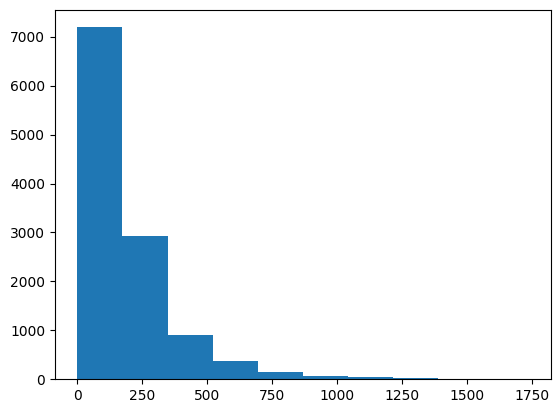

In [72]:
new_lengths = [len(review_sequence) for review_sequence in X_lemmatized]
plt.hist(new_lengths, bins=10)

In [76]:
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.20, random_state=1)

In [77]:
num_words=10000
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(X_train)

In [78]:
X_train_token = tokenizer.texts_to_sequences(X_train)
X_test_token = tokenizer.texts_to_sequences(X_test)

In [79]:
X_train_pad = pad_sequences(X_train_token, dtype='float32', padding='pre', maxlen=200, truncating='pre')
X_test_pad = pad_sequences(X_test_token, dtype='float32', padding='pre', maxlen=200, truncating='pre')

# Changed this to 200 maxlen to see if it speeds up runtime

## Now constructing, fitting and training the RNN

In [80]:
vocab_size = len(tokenizer.word_index)
vocab_size

42082

In [81]:
embedding_dimension = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size + 1, output_dim=embedding_dimension, mask_zero=True))
model.add(layers.LSTM(20))
model.add(layers.Dense(10, activation="relu"))
model.add(layers.Dense(1, activation="linear"))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])

In [82]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 50)          2104150   
                                                                 
 lstm (LSTM)                 (None, 20)                5680      
                                                                 
 dense (Dense)               (None, 10)                210       
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 2,110,051
Trainable params: 2,110,051
Non-trainable params: 0
_________________________________________________________________


In [83]:
es = EarlyStopping(patience=5, restore_best_weights=True)

model.fit(X_train_pad, y_train, 
          epochs=20, 
          batch_size=32, # higher batch size than optimal to speed up testing
          validation_split=0.3,
          callbacks=[es]
         )

Epoch 1/20
205/205 [==============================] - 37s 160ms/step - loss: 4.8633 - mae: 1.7088 - val_loss: 1.8060 - val_mae: 1.0225
Epoch 2/20
205/205 [==============================] - 30s 147ms/step - loss: 1.6462 - mae: 0.9941 - val_loss: 1.7152 - val_mae: 1.0273
Epoch 3/20
205/205 [==============================] - 30s 146ms/step - loss: 1.4525 - mae: 0.9419 - val_loss: 1.6583 - val_mae: 1.0019
Epoch 4/20
205/205 [==============================] - 30s 144ms/step - loss: 1.0864 - mae: 0.8019 - val_loss: 1.4409 - val_mae: 0.9010
Epoch 5/20
205/205 [==============================] - 29s 143ms/step - loss: 0.7150 - mae: 0.6398 - val_loss: 1.4412 - val_mae: 0.9017
Epoch 6/20
205/205 [==============================] - 31s 149ms/step - loss: 0.5091 - mae: 0.5421 - val_loss: 1.4577 - val_mae: 0.8883
Epoch 7/20
205/205 [==============================] - 31s 149ms/step - loss: 0.3889 - mae: 0.4719 - val_loss: 1.5289 - val_mae: 0.9245
Epoch 8/20
205/205 [==============================] - 3

## Baseline for comparison

In [84]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [85]:
y_train.value_counts()

5    4491
4    2490
3     962
1     781
2     622
Name: review score, dtype: int64

(array([ 781.,  622.,  962., 2490., 4491.]),
 array([1. , 1.8, 2.6, 3.4, 4.2, 5. ]),
 <BarContainer object of 5 artists>)

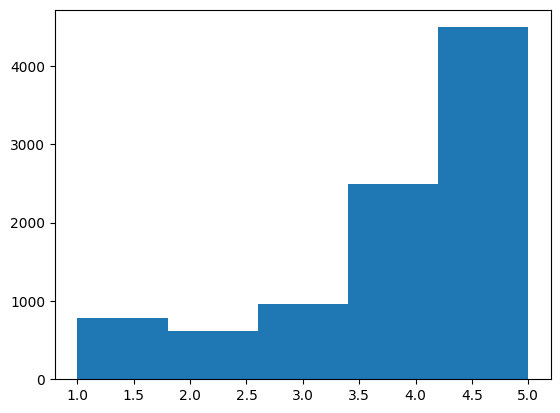

In [92]:
plt.hist(y_train, bins=5)

In [ ]:
y_train.shape

In [93]:
baseline_predictions = [5]*len(y_test)

In [94]:
baseline_mse_score = mean_squared_error(y_test, baseline_predictions)
baseline_mse_score

2.7248609328198543

In [95]:
baseline_mae_score = mean_absolute_error(y_test, baseline_predictions)
baseline_mae_score

1.0500641848523748

## Evaluate model on test set

In [96]:
model.evaluate(X_test_pad, y_test)

74/74 [==============================] - 2s 27ms/step - loss: 1.5088 - mae: 0.9335


[1.5088489055633545, 0.9334921836853027]

In [97]:
[baseline_mse_score, baseline_mae_score]

[2.7248609328198543, 1.0500641848523748]